In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

import numpy as np
#import pandas as pd

%matplotlib inline

In [2]:
#importing funcitons from ScalarRepresentation-tests notebook
#import nbimporter
#import ScalarRepresentation_tests as ScalarRep

In [3]:
#from ScalarRepresentation_tests import Ensemble, Neuron, neuron_creation, neuron_evaluator, param_creation

## Goal

As with the previous scalar representation the goal here is to be able to randomly create neurons and synapses and be able to find a linear decoder that is able to correctly decode the non-linear encoded value.

To do this, in this section, instead of considering that the neuron has only one input and one output, I'll start playing with synapse weights. 

The goal is to understand how to generate different synapse weights (with some random values of a certain distribution) without the need to train the system, and only finding (training) the linear decoder.

## First Vector Representation Experience

The main point of this notebook is to understand how to represent nicely vectors with the same neuron populations as the Scalars.

For this exercise I'll start considering that the input current is limited to the range [-1;1] and this implies that bigger currents (module) than this can not be represented.
This means that if the input is saturated by one of the synapses, the other synapses contributions to the neural input current will be maybe ignored.

I propose the following ideas to study the behaviour:

* All synapse values are equal and the sum is 1
* Uniform random distribution of the variables, where all synapse values add to a maximum of 1 (one), this might be done doing the synapse weights first [0,1], then [0,1-s1], [0,1-s1-s2], .... ,[0,1-s1-s2-....-sn] .. this might be good to take into account negative numbers too
* Gaussian distribution (attention) for each neuron on the input values of the input vector
* Try other distributions (as attention) to input values of the vector

**Questions**:

 - Should I use NEGATIVE synapse values?
 - If so: How to take care of NEGATIVE synapse values?

### Case Study - All synapses sum 1




In [4]:
class VectorNeuron(object):
    def __init__(self, a, b, sat, weights):
        self.a = a
        self.b = b
        self.saturation = sat
        self.weights=weights

In [5]:
def vector_neuron_creation(n_synapses, min_y=0.5, max_y=1.5, min_x=-1.0, max_x=1.0, saturation=None):
    """
    This model creates two points, one in x range, one in y range, then decides if a >0 or a<0.
    Depending on the sign (which will be the sign of a), will resolve the linear equation to find 
    a and b
    """
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    #the first point is for y=0 
    x1 = random.uniform(-1,1)
    y1 = 0
    #the second point is for x=+-1 
    x2 = s
    y2 = random.uniform(min_y,max_y)
    
    a = (y1-y2)/(x1-x2)
    b = y1 - a*x1
    
    weights = [1.0/n_synapses for s in range(n_synapses)] #do the test with synapse weight = 1
    return VectorNeuron(a,b,saturation, np.array(weights))

In [6]:
# Definition of function evaluation

def limited_vector_neuron_evaluator(x, neuron ):
    a = neuron.a
    b = neuron.b
    sat=neuron.saturation
#     print(x.shape, neuron.weights.shape)
    current = x.transpose().dot(neuron.weights)
#     print(current, current.shape)
    return max(0, min(a*current + b, sat))
    

def vector_neuron_evaluator(x, neuron ):
    a = neuron.a
    b = neuron.b
    sat = neuron.saturation
    current = x.transpose().dot(neuron.weights)
    return max(0, a*current + b)

In [7]:
class VectorEnsemble(object):
    def __init__(self, vect_dimension, n_neurons, min_y=0.5, max_y=1.5, max_x=1,min_x=-1,saturation=None):
        self.neurons = [vector_neuron_creation(vect_dimension, min_y, max_y, max_x, saturation) for i in range(n_neurons)]

    def encode_saturation(self, inputs):
        """
        For every point in the input will calculate all the outputs for all the neurons
        """
        output = []
        for x in inputs:
            outpoint = []
            for n in self.neurons:
                v = limited_vector_neuron_evaluator(x, n)
                outpoint.append(v)
            output.append(outpoint)
        return np.array(output)
    
    def encode(self, inputs):
        """
        For every point in the input will calculate all the outputs for all the neurons
        """
        output = []
        for x in inputs:
            outpoint = []
            for n in self.neurons:
                v = vector_neuron_evaluator(x, n)
                outpoint.append(v)
            output.append(outpoint)
        return np.array(output)

In [8]:
#make ensembles for different dimensions, the ensambles will have 1000 neurons each
#dimensions is the input dimension of the function
ensembles = []

#dimensions = [2,3,5,10,20,50,100,1000, 10000]
dimensions = [2,3,4,10]

n_neurons = 100

for d in dimensions:
    ensembles.append(VectorEnsemble(d, n_neurons))


For the higher dimensional spaces I might try with random number generation and see what happens, only measuring the mean square error on reconstruction

For the 2 and 3 dimensional vector I will try with already known functions and see if I can graph them

In [9]:
xt = np.linspace(0, 8*np.pi, 1000)
fsin = np.sin(xt)
fcos = np.cos(xt)
# farcos = np.arccos(xt)
# farccosh = np.arccosh(xt)
# farcsin = np.arcsin(xt)
farcsinh = np.arcsinh(xt)
xlasc = np.linspace(0,1,1000)
xldes = np.linspace(1,0,1000)


In [10]:
ind4 = np.column_stack((fsin, fcos, xlasc, xldes))
ind5 = np.column_stack((fsin, fcos, xlasc, xldes, farcsinh))
#using the arcsinh function, as values are greater than 1 in the input and the synapse is not yet limited
#it breaks BAAAADLY the decoding
ind5=ind4 #redefining so just I don't have to rewrite all the code below.

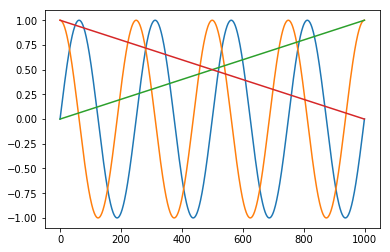

In [11]:
plt.plot(range(1000), ind4);

In [12]:
n_vectors = 1000#00

inputs = [np.random.rand(n_vectors,d) for d in dimensions]

Now I have to fit the linear decoders, for this I first have to calculate the encoded values for all those elements.

The training will be done not with all the elements but with a few times the dimension of the input vector

In [13]:
ins = ind4 #inputs[0]
ens = ensembles[2]

In [14]:
encs = ens.encode_saturation(ind4)
encns = ens.encode(ind4)

In [15]:
len(encs)

1000

In [16]:
print(ins.size, len(ens.neurons), encs.size,encns.size)

4000 100 100000 100000


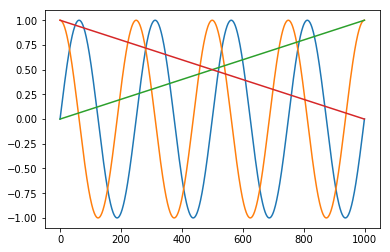

In [17]:
plt.plot(range(n_vectors), ins);

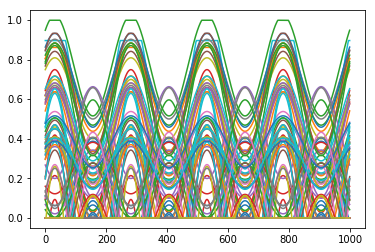

In [18]:
plt.plot(range(n_vectors), encs);

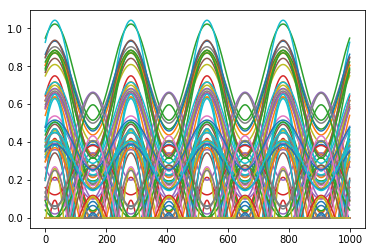

In [19]:
plt.plot(range(n_vectors), encns, "-");

In [20]:
%%time

encoded_sat = []
encoded_nosat = []

for i in range(len(dimensions)- 2):
    ins = inputs[i]
    ens = ensembles[i]
    encs = ens.encode_saturation(ins)
    encoded_sat.append(encs)
    encns = ens.encode(ins)
    encoded_nosat.append(encns)

CPU times: user 456 ms, sys: 8 ms, total: 464 ms
Wall time: 427 ms


I have to find some function that will do all the linear decoding for different dimensions in one shot.
For the moment I'll just create a linear decoder per dimension

In [21]:

decoders = []

for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][:50] #only take the first 20 points of the functions
    lm = linear_model.LinearRegression()
    model = lm.fit(encs[:50],foo)
    decoders.append(model)

In [22]:
#now evaluate the results with those numbers
for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][50:]
    d = decoders[i]
    print (d.score(encs[50:], foo))

-7.70891935348e+18
-4.03105852577e+18
-1.30360239419e+17
-1.30360239419e+17


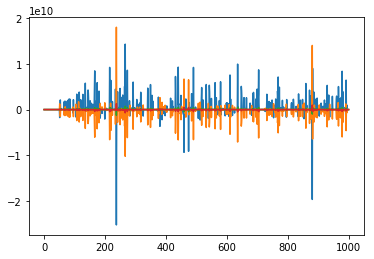

In [23]:
for d in decoders:
    plt.plot(range(n_vectors), d.predict(encs))

As we can see, the results of this show that the results of the decoders are actually bad, the encoding operation was not good enough for this to result in some nice decoder.

I tried using arcsinh and no arcsinh, both give bad results, the worst are with the function arcsinh (which gives inputs bigger than 1 .. TODO limit 

The issue I imagine is the weights asignation algorithm, all weights similar give no discrimination strategy.

I will try with different weighting algorithms, as I think this should change the results.

-2.64736612338e+17
-1.06861165843e+18
-3.87724557763e+18
-3.87724557764e+18


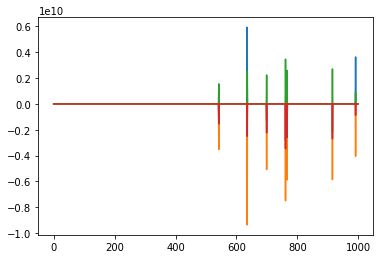

In [24]:
decoders = []

ntrain = 500

for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][:ntrain] #only take the first 20 points of the functions
    lm = linear_model.LinearRegression()
    model = lm.fit(encs[:ntrain],foo)
    decoders.append(model)
    
#now evaluate the results with those numbers
for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][ntrain:]
    d = decoders[i]
    print (d.score(encs[ntrain:], foo))
    
for d in decoders:
    plt.plot(range(n_vectors), d.predict(encs))

In [25]:
#redefining the vector creation function to allow for the neurons different totally random synapse weights

def rand_vector_neuron_creation(n_synapses, min_y=0.5, max_y=1.5, min_x=-1.0, max_x=1.0, saturation=None):
    """
    This model creates two points, one in x range, one in y range, then decides if a >0 or a<0.
    Depending on the sign (which will be the sign of a), will resolve the linear equation to find 
    a and b
    """
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    #the first point is for y=0 
    x1 = random.uniform(-1,1)
    y1 = 0
    #the second point is for x=+-1 
    x2 = s
    y2 = random.uniform(min_y,max_y)
    
    a = (y1-y2)/(x1-x2)
    b = y1 - a*x1
    weights = [random.random() for s in range(n_synapses)] #do the test with synapse weight = 1
    return VectorNeuron(a,b,saturation, np.array(weights))

In [26]:
#now redefine the weights function here, so I can redo the study
vector_neuron_creation = rand_vector_neuron_creation

In [27]:
n = rand_vector_neuron_creation(10)

In [28]:
n.weights

array([ 0.33498528,  0.66994207,  0.44821122,  0.57137184,  0.85386864,
        0.52258699,  0.9099368 ,  0.97386251,  0.51311865,  0.41250543])

I will repeat now all the same procedures as for the previous try

In [29]:
#make ensembles for different dimensions, the ensambles will have 1000 neurons each
#dimensions is the input dimension of the function
ensembles = []

#dimensions = [2,3,5,10,20,50,100,1000, 10000]
dimensions = [2,3,4,10]

for d in dimensions:
    ensembles.append(VectorEnsemble(d, 20))

    xt = np.linspace(0, 8*np.pi, 1000)

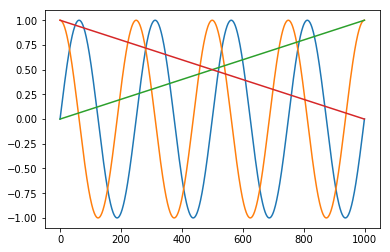

In [30]:
    
fsin = np.sin(xt)
fcos = np.cos(xt)
# farcos = np.arccos(xt)
# farccosh = np.arccosh(xt)
# farcsin = np.arcsin(xt)
# farcsinh = np.arcsinh(xt)
xlasc = np.linspace(0,1,1000)
xldes = np.linspace(1,0,1000)

plt.plot(range(1000), ind4);

In [31]:
ins = ind4 #inputs[0]
ens = ensembles[2]

encs = ens.encode_saturation(ind4)
encns = ens.encode(ind4)

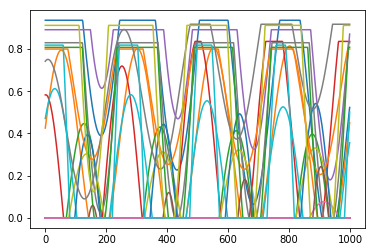

In [32]:
plt.plot(range(n_vectors), encs);

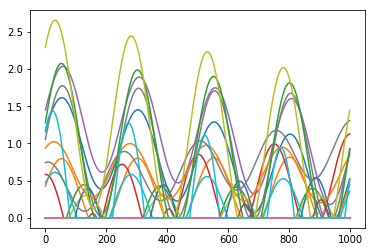

In [33]:
plt.plot(range(n_vectors), encns);

Seems that a few particular values are taking control of all the elements.

I think I should ALSO limit the Post Synaptic Current (PSC) for each connexion

0.95678329159
0.510398106412
-0.872914071414
-0.838550276862


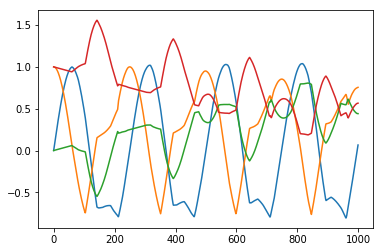

In [34]:
decoders = []

for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][:50] #only take the first 20 points of the functions
    lm = linear_model.LinearRegression()
    model = lm.fit(encs[:50],foo)
    decoders.append(model)
    
#now evaluate the results with those numbers
for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][50:]
    d = decoders[i]
    print (d.score(encs[50:], foo))
    
for d in decoders:
    plt.plot(range(n_vectors), d.predict(encs))

0.987603138152
0.974889533379
0.00815694528696
0.00815694528696


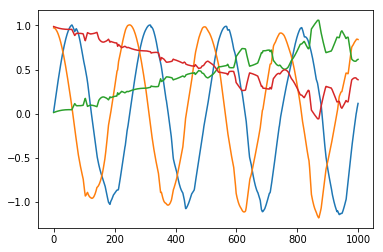

In [35]:
decoders = []

ntrain = 500

for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][:ntrain] #only take the first 20 points of the functions
    lm = linear_model.LinearRegression()
    model = lm.fit(encs[:ntrain],foo)
    decoders.append(model)
    
#now evaluate the results with those numbers
for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][ntrain:]
    d = decoders[i]
    print (d.score(encs[ntrain:], foo))
    
for d in decoders:
    plt.plot(range(n_vectors), d.predict(encs))

The previous approach does not seem to correct any problem, on the contrary, things are getting even more weird

In [36]:
#this neuron creation model will maintain a maximum weight sum of 1, taking in account the previous weight sum

def rand_sum1_vector_neuron_creation(n_synapses, min_y=0.5, max_y=1.5, min_x=-1.0, max_x=1.0, saturation=None):
    """
    This model creates two points, one in x range, one in y range, then decides if a >0 or a<0.
    Depending on the sign (which will be the sign of a), will resolve the linear equation to find 
    a and b
    """
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    #the first point is for y=0 
    x1 = random.uniform(-1,1)
    y1 = 0
    #the second point is for x=+-1 
    x2 = s
    y2 = random.uniform(min_y,max_y)
    
    a = (y1-y2)/(x1-x2)
    b = y1 - a*x1
    
    weight_sum = 0
    weights = []
    for s in range(n_synapses):
        weights.append(random.uniform(0, 1-weight_sum))
        weights_sum = np.sum(weights)
    return VectorNeuron(a,b,saturation, np.array(weights))

In [37]:
#now redefine the weights function here, so I can redo the study
vector_neuron_creation = rand_sum1_vector_neuron_creation

In [38]:
#make ensembles for different dimensions, the ensambles will have 1000 neurons each
#dimensions is the input dimension of the function
ensembles = []

#dimensions = [2,3,5,10,20,50,100,1000, 10000]
dimensions = [2,3,4,10]

for d in dimensions:
    ensembles.append(VectorEnsemble(d, 20))

    xt = np.linspace(0, 8*np.pi, 1000)

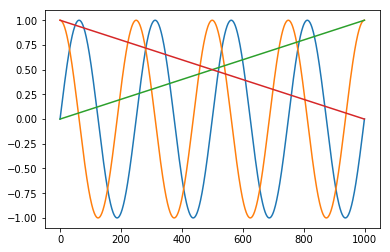

In [39]:
    
fsin = np.sin(xt)
fcos = np.cos(xt)
# farcos = np.arccos(xt)
# farccosh = np.arccosh(xt)
# farcsin = np.arcsin(xt)
# farcsinh = np.arcsinh(xt)
xlasc = np.linspace(0,1,1000)
xldes = np.linspace(1,0,1000)

plt.plot(range(1000), ind4);

In [40]:
ins = ind4 #inputs[0]
ens = ensembles[2]

encs = ens.encode_saturation(ind4)
encns = ens.encode(ind4)

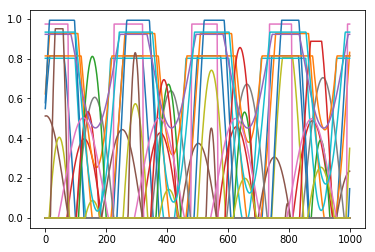

In [41]:
plt.plot(range(n_vectors), encs);

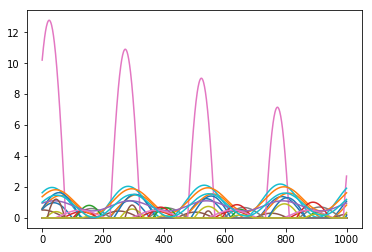

In [42]:
plt.plot(range(n_vectors), encns);

Seems that a few particular values are taking control of all the elements.

I think I should ALSO limit the Post Synaptic Current (PSC) for each connexion

-1.35198681079e+12
-9689085662.88
-4988560540.01
-4988563454.72


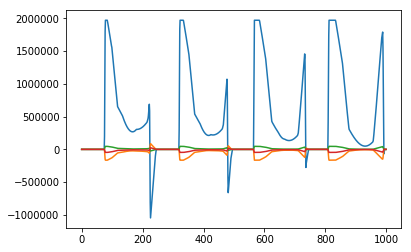

In [43]:
decoders = []

for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][:50] #only take the first 20 points of the functions
    lm = linear_model.LinearRegression()
    model = lm.fit(encs[:50],foo)
    decoders.append(model)
    
#now evaluate the results with those numbers
for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][50:]
    d = decoders[i]
    print (d.score(encs[50:], foo))
    
for d in decoders:
    plt.plot(range(n_vectors), d.predict(encs))

0.995503616226
0.996454793954
0.472944320218
0.472944320218


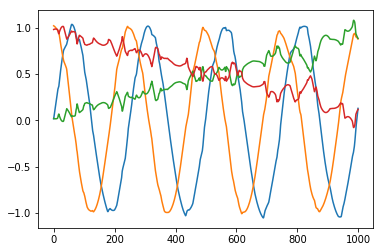

In [44]:
decoders = []

ntrain = 500

for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][:ntrain] #only take the first 20 points of the functions
    lm = linear_model.LinearRegression()
    model = lm.fit(encs[:ntrain],foo)
    decoders.append(model)
    
#now evaluate the results with those numbers
for i in range(len(ind5[0])):
    foo = ind5.transpose()[i][ntrain:]
    d = decoders[i]
    print (d.score(encs[ntrain:], foo))
    
for d in decoders:
    plt.plot(range(n_vectors), d.predict(encs))

These results are also weird, I think I need to get back to the math and theory on how to decompose this results.

The only issue was with the number of training points!!!!!!

Assuming that the number of neurons in the Ensemble is changed too, then it should ALSO provide a better encoding

I tried first with 20 neurons per ensemble, then with 100 neurons per ensemble.


The result is clear that with more Neurons per ensemble and more training points for the linear regresor the results get better.

In the case of weight asignation policy, the completely random one was MUCH BETTER than the other two policies.

Now I will redo all this, in a new notebook, but adding a PSC limitation of 1 (or even with lower bounds, so the actual internal current as is max 1, but the PSC for each dendrite will be less, for example, 0.8, leaving place for other connections to play there, this should also change the weight synapse interval)



In [45]:
lm = linear_model.LinearRegression()
model = lm.fit(encs[:200],ind5[:200])


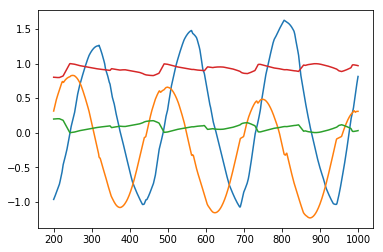

In [46]:
plt.plot(range(200,1000), model.predict(encs[200:]))